In [2]:
import pandas as pd

In [3]:
air_df = pd.read_csv('air-passengers.csv')
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
display(air_df)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [5]:
air_df['Month'] = pd.to_datetime(air_df['Month'])
air_df.set_index('Month',drop=True, inplace=True)

In [6]:
air_df.sort_values(by='Month', inplace=True)


In [7]:
print(air_df)

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]


In [8]:
import matplotlib.pyplot as plt

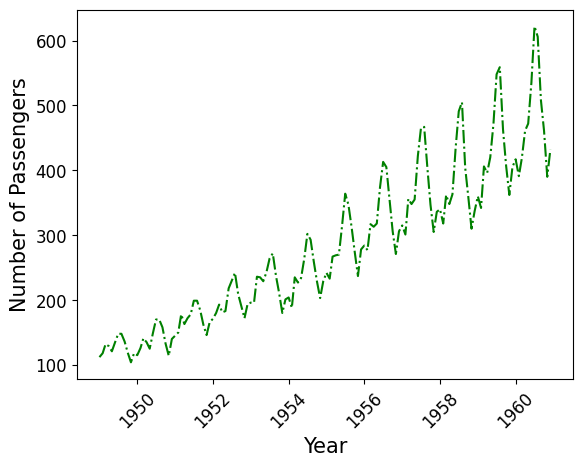

In [9]:
# Plot time series
plt.plot(air_df['Passengers'],'g-.')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Passengers', fontsize=15)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

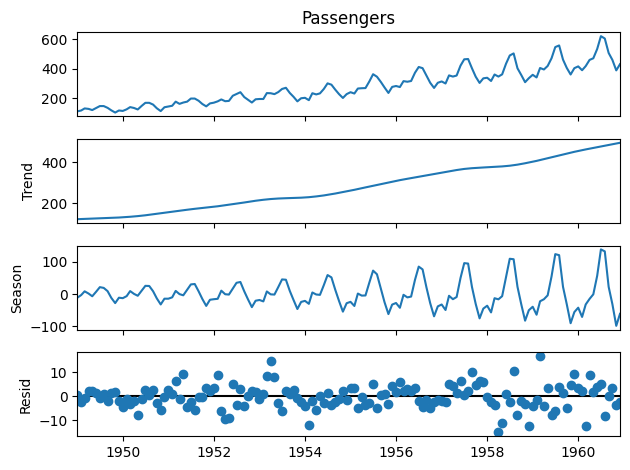

In [10]:
from statsmodels.tsa.seasonal import STL
STL(air_df['Passengers']).fit().plot()
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller
ADF_test = adfuller(air_df['Passengers'])[:2]
print(f"ADF Statistic: {ADF_test[0]}; p-value {ADF_test[1]}")

ADF Statistic: 0.8153688792060441; p-value 0.9918802434376409


In [12]:
diff_1 = air_df[['Passengers']].diff(1).dropna()
diff_1

,Passengers
Month,
1949-02-01,6.0
1949-03-01,14.0
1949-04-01,-3.0
1949-05-01,-8.0
1949-06-01,14.0
...,...
1960-08-01,-16.0
1960-09-01,-98.0
1960-10-01,-47.0


In [13]:
ADF_test = adfuller(diff_1)[:2]
print(f"ADF Statistic: {ADF_test[0]}; p-value {ADF_test[1]}")

ADF Statistic: -2.8292668241700034; p-value 0.05421329028382497


In [14]:
ADF_test = adfuller(diff_1)[:2]
print(f"ADF Statistic: {ADF_test[0]}; p-value {ADF_test[1]}")

ADF Statistic: -2.8292668241700034; p-value 0.05421329028382497


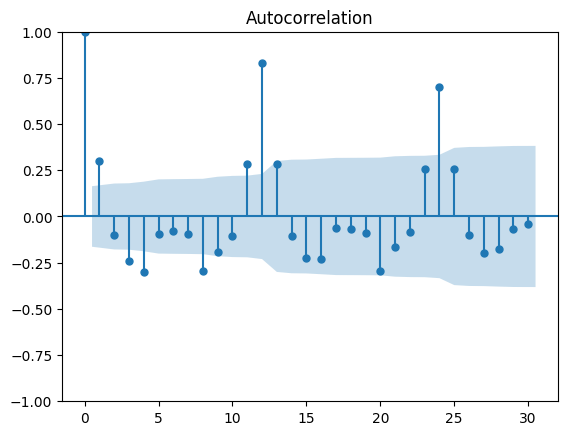

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(diff_1, lags=30)
plt.show()

In [16]:
from itertools import product
import numpy as np
ps = np.arange(0,13,1) # Order of AR
qs = np.arange(0,13,1) # Order of MA
Ps = [0] # Seasonal order of AR
Qs = [0] # Seasonal order of MA
d=2 # number of times the series is differenced to attain stationarity
D = 0 # Seasonal differencing
s= 12 # period
p_q_list = list(product(ps,qs,Ps,Qs))
p_q_list[:5]
# Function to get the best AIC values
def aic_values(target):
    """This functions accepts a series and returns the aic values"""
    list_of_aic = []
    for order in p_q_list:
        try:
            model = SARIMAX(endog=target, order=(order[0], d, order[1]),seasonal_order=(order[2], D, order[3], s),
            simple_differencing=False).fit(disp=False)
        except:
            continue
        list_of_aic.append([order, model.aic])
    aic_df = pd.DataFrame(list_of_aic, columns = ['Order(p,q,Ps,QS)','AIC'])
    aic_df.sort_values(by='AIC', ascending=True,inplace=True)#.reset_index(drop=True)
    return  aic_df



In [17]:
# Splitting the dataset into train and test set
train = air_df[['Passengers']][:-12]# all the years before the last month
test = air_df[['Passengers']][-12:] # predicting the last 12 months
aic_df = aic_values(train)
display(aic_df)

,"Order(p,q,Ps,QS)",AIC


In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
rima_model = SARIMAX(endog=train, order=(11, 2,3)).fit()

C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Program Files\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

,lb_stat,lb_pvalue
1,6.551736,0.010478
2,6.678223,0.035468
3,6.955102,0.073343
4,7.748967,0.101219
5,8.392815,0.135874
6,8.678811,0.192463
7,9.493198,0.219158
8,9.731450,0.284383
9,9.741756,0.371793
10,11.533135,0.317516


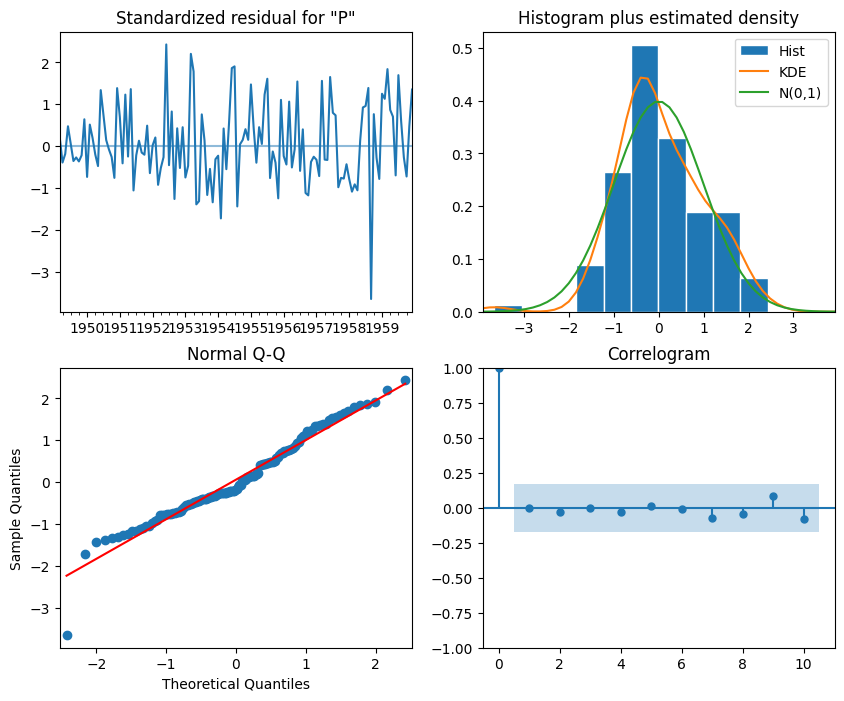

In [19]:
# Plots the Q-Q plot
rima_model.plot_diagnostics(figsize=(10,8));
# Evaluation using Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(rima_model.resid)

In [20]:
len_test = len(test)
arima_pred = rima_model.get_forecast(len_test).predicted_mean.values
naive_pred = train['Passengers'][len(train)-12:len(train)].values
test['naive_pred'] = naive_pred
test['arima_pred'] = arima_pred
test

,Passengers,naive_pred,arima_pred
Month,,,
1960-01-01,417,360,422.331506
1960-02-01,391,342,410.650099
1960-03-01,419,406,461.839948
1960-04-01,461,396,457.789874
1960-05-01,472,420,481.663885
1960-06-01,535,472,531.050089
1960-07-01,622,548,606.145300
1960-08-01,606,559,615.451862
1960-09-01,508,463,525.629086


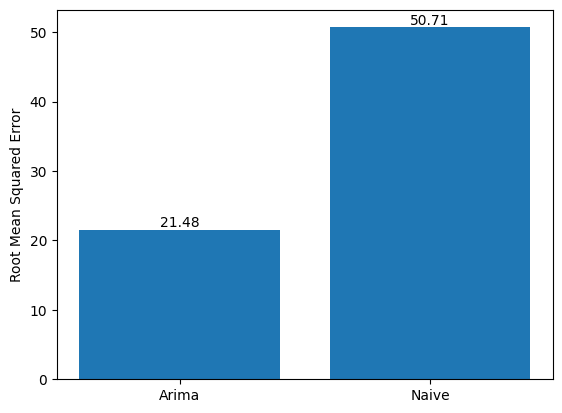

In [21]:
from sklearn.metrics import mean_squared_error

arima_rmse = mean_squared_error(test['Passengers'],test['arima_pred'],
squared=False)
naive_rmse = mean_squared_error(test['Passengers'],test['naive_pred'],
squared=False)
# plotting the results
list_rmse = [arima_rmse,naive_rmse]
models = ['Arima', 'Naive']
plt.bar(x=models,height=list_rmse)
plt.ylabel('Root Mean Squared Error')
for i, value in enumerate(list_rmse):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')
plt.show()

In [ ]:
df_diff_seasonal = diff_1[['Passengers']].diff(12).dropna()
adfuller(df_diff_seasonal)[:2]
# Specifying a range of parameters to determine the order using AIC
from itertools import product
ps = np.arange(0,13,1) # Order of AR
qs = np.arange(0,13,1) # Order of MA
Ps = np.arange(0,13,1) # Seasonal order of AR
Qs = np.arange(0,13,1) # Seasonal order of MA
d=1 # 1 normal differencing
D = 1 # 1 Seasonal differencing
s= 12 # period
p_q_list = list(product(ps,qs,Ps,Qs))
aic_df = aic_values(train)
aic_df



C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will b

In [1]:
# fitting the SARIMA model based on the lowest AIC
sarima_model = SARIMAX(endog=train, order=(2, 1,1), seasonal_order=(1, 1, 2,
12)).fit()
sarima_model

NameError: name 'SARIMAX' is not defined

In [ ]:

#Using Ljungbox to test for autocorrelation of the residual
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(sarima_model.resid)
# Making predictions with the model
len_test = len(test) # this also referred to as the window of forecast
sarima_pred = sarima_model.get_forecast(len_test)
sarima_pred = sarima_pred.predicted_mean
print(sarima_pred)
# Assiging the prediction to the test set dataframe
test['sarima_pred'] = sarima_pred
test